# Objectifs : Transposer les calculs des indicateurs du package R peinnar en python

## Chargement des library

In [1]:
import pandas as pd 
import xarray as xr
import datetime as dt 
import numpy as np

In [64]:
ModelTas=xr.open_dataset("data/tasAdjust_France_MPI-M-MPI-ESM-LR_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_MF-ADAMONT-SAFRAN-1980-2011_day_19500101-20051231.nc")

In [65]:
ModelTas

<xarray.Dataset>
Dimensions:         (x: 143, y: 134, time: 20454)
Coordinates:
  * x               (x) float64 6e+04 6.8e+04 7.6e+04 ... 1.188e+06 1.196e+06
  * y               (y) float64 1.617e+06 1.625e+06 ... 2.673e+06 2.681e+06
  * time            (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2005-12-31
    lat             (y, x) float64 ...
    lon             (y, x) float64 ...
Data variables:
    LambertParisII  float64 ...
    tasAdjust       (time, y, x) float32 ...
Attributes: (12/40)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    comment:                        CORDEX Europe RCM CCLM 0.11 deg EUR-11
    ...                             ...
    bc_period_ref:                  1980-2011
    bc_period_rcm:                  1974-2005
    bc_info:                        Meteo-France-ADAMONT-France_SAFRAN-France...
    product:                        bias-correction
    bc_comment:                     Weather Regime dependant BC methode
    Conventions:                    CF-1.6

In [18]:
def CalculIndicator(x, NameIndicator, seuil):
    classMoy = ["mint", "maxt", "meant", "avsorad"]
    classDaySup = ["hdaystmax", "hdaystmin", "hdaystmean", "excraidays"]
    classSum = ["rainsum", "sumetp"]
    classDayInf = ["cdaystmin", "defraidays"]
    classFreqSup = ["raifreq", "excraifreq", "hsfreq"]
    classFreqInf = ["cfreqtmean", "cfreqtmin"]

    # Extraire les jours juliens de début et fin et les valeurs
    start_day = x[0].dt.dayofyear.values
    end_day = x[1].dt.dayofyear.values
    val = val = x[var_name].values  # Utilisez le nom de la variable passé en argument

    if pd.isna(start_day) or pd.isna(end_day):
        resu = float('nan')
    else:
        # Convertir les jours en indices (0-based)
        start_idx = start_day - 1
        end_idx = end_day - 1
        
        if NameIndicator in classMoy:
            resu = np.mean(val[start_idx:end_idx+1])
            
        elif NameIndicator in classDaySup:
            val_slice = val[start_idx:end_idx+1]
            resu = np.sum(val_slice > seuil)
            
        elif NameIndicator in classSum:
            resu = np.sum(val[start_idx:end_idx+1])
            
        elif NameIndicator in classDayInf:
            val_slice = val[start_idx:end_idx+1]
            resu = np.sum(val_slice < seuil)
            
        elif NameIndicator in classFreqSup:
            val_slice = val[start_idx:end_idx+1]
            resu = (np.sum(val_slice > seuil) * 100) / len(val_slice)
            
        elif NameIndicator in classFreqInf:
            val_slice = val[start_idx:end_idx+1]
            resu = (np.sum(val_slice < seuil) * 100) / len(val_slice)
            
    return resu

In [146]:
def compute_indicator_netcdf(climate_data, NameIndicator, varName, threshold=None, two_years_culture=True, start_stage=None, end_stage=None):
    classMoy = ["mint", "maxt", "meant", "avsorad"]
    classDaySup = ["hdaystmax", "hdaystmin", "hdaystmean", "excraidays"]
    classSum = ["rainsum", "sumetp"]
    classDayInf = ["cdaystmin", "defraidays"]
    classFreqSup = ["raifreq", "excraifreq", "hsfreq"]
    classFreqInf = ["cfreqtmean", "cfreqtmin"]
   
    import xarray as xr
    import pandas as pd
    import numpy as np
    
    # Get time information
    time = climate_data.time
    
    # Vérifier si le dataset n'est pas vide
    if len(time) == 0:
        return xr.Dataset()
        
    doy = pd.DatetimeIndex(time.values).dayofyear
    
    # Create start and end arrays
    if isinstance(start_stage, (int, float)):
        rast_start = xr.full_like(climate_data[varName].isel(time=0), start_stage)
    
    if isinstance(end_stage, (int, float)):
        rast_end = xr.full_like(climate_data[varName].isel(time=0), end_stage)
    
    # Get unique years
    years = pd.DatetimeIndex(time.values).year.unique()
    
    # Process each year
    results = []
    for year in years:
        print(year)
        
        if two_years_culture:
            # Select current and previous year
            mask = ((time.dt.year == year) | (time.dt.year == year-1))
            rast_year = climate_data.sel(time=mask)
            
            if len(rast_year.time) < 367:
                result = xr.full_like(climate_data[varName].isel(time=0), np.nan)
                results.append(result)
                continue
                
        else:
            # Select only current year
            rast_year = climate_data.sel(time=time.dt.year==year)
            if len(rast_year.time) < 367:
                result = xr.full_like(climate_data[varName].isel(time=0), np.nan)
                results.append(result)
                continue
                
        if isinstance(start_stage, xr.DataArray):
            rast_start = start_stage.sel(time=time.dt.year==year)
            
        if isinstance(end_stage, xr.DataArray):
            rast_end = end_stage.sel(time=time.dt.year==year)
            
        # Apply calculation
        if NameIndicator in classMoy:
            result = xr.apply_ufunc(
                lambda x, start, end: np.mean(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)]),
                rast_year[varName],
                rast_start,
                rast_end,
                input_core_dims=[['time'], [], []],
                vectorize=True)

        elif NameIndicator in classDaySup:
            result = xr.apply_ufunc(
                lambda x, start, end: np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)] > threshold),
                rast_year[varName],
                rast_start,
                rast_end,
                input_core_dims=[['time'], [], []],
                vectorize=True)
                
        elif NameIndicator in classSum:
            result = xr.apply_ufunc(
                lambda x, start, end: np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)]),
                rast_year[varName],
                rast_start,
                rast_end,
                input_core_dims=[['time'], [], []],
                vectorize=True)
                
        elif NameIndicator in classDayInf:
            result = xr.apply_ufunc(
                lambda x, start, end: np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)] < threshold),
                rast_year[varName],
                rast_start,
                rast_end,
                input_core_dims=[['time'], [], []],
                vectorize=True)
       
        elif NameIndicator in classFreqSup:
            result = xr.apply_ufunc(
                lambda x, start, end: (np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)] > threshold) * 100) / np.sum((np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)),
                rast_year[varName],
                rast_start,
                rast_end,
                input_core_dims=[['time'], [], []],
                vectorize=True)
            #result = result.assign_coords(year=year)    
        #result = result.assign_coords(year=year)
        results.append(result)

     
        
    # Combine results
    if results:
        output = xr.concat(results, dim="year").to_dataset()
        output = output.rename({varName: NameIndicator})
        return output
    else:
        return xr.Dataset()


In [116]:
dataTemp=ModelTas.sel(time=slice('2001','2005'))


In [117]:
dataTemp=dataTemp-273.15
dataTemp

<xarray.Dataset>
Dimensions:         (x: 143, y: 134, time: 1826)
Coordinates:
  * x               (x) float64 6e+04 6.8e+04 7.6e+04 ... 1.188e+06 1.196e+06
  * y               (y) float64 1.617e+06 1.625e+06 ... 2.673e+06 2.681e+06
  * time            (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2005-12-31
    lat             (y, x) float64 ...
    lon             (y, x) float64 ...
Data variables:
    LambertParisII  float64 -2.147e+09
    tasAdjust       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/40)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    comment:                        CORDEX Europe RCM CCLM 0.11 deg EUR-11
    ...                             ...
    bc_period_ref:                  1980-2011
    bc_period_rcm:                  1974-2005
    bc_info:                        Meteo-France-ADAMONT-France_SAFRAN-France...
    product:                        bias-correction
    bc_comment:                     Weather Regime dependant BC methode
    Conventions:                    CF-1.6

In [154]:
test=compute_indicator_netcdf(climate_data=dataTemp, NameIndicator="hsfreq",threshold=20,varName="tasAdjust", two_years_culture=True, start_stage=1, end_stage=365)

2001
2002
2003
2004
2005


In [152]:
test

<xarray.Dataset>
Dimensions:  (x: 143, y: 134, year: 5)
Coordinates:
  * x        (x) float64 6e+04 6.8e+04 7.6e+04 ... 1.18e+06 1.188e+06 1.196e+06
  * y        (y) float64 1.617e+06 1.625e+06 1.633e+06 ... 2.673e+06 2.681e+06
    time     datetime64[ns] 2001-01-01
    lat      (y, x) float64 41.36 41.37 41.37 41.38 ... 50.86 50.85 50.84 50.83
    lon      (y, x) float64 -4.097 -4.002 -3.907 -3.812 ... 10.57 10.68 10.79
Dimensions without coordinates: year
Data variables:
    meant    (year, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

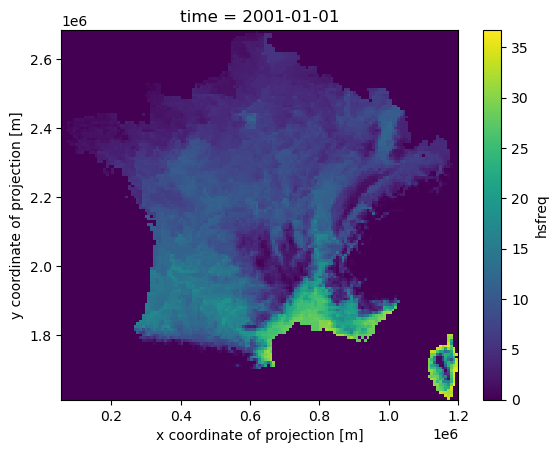

In [156]:
test.isel(year=1).hsfreq.plot()

In [123]:
year=2001
start_stage= 1
end_stage = 365
climate_data=dataTemp
NameIndicator="mint"
two_years_culture=True
threshold=None
varName="tasAdjust"
classMoy = ["mint", "maxt", "meant", "avsorad"]

In [124]:
time = climate_data.time
doy = pd.DatetimeIndex(time.values).dayofyear

years = pd.DatetimeIndex(time.values).year.unique()

In [125]:
rast_year = climate_data.sel(time=time.dt.year==year)

In [126]:
if isinstance(start_stage, (int, float)):
    rast_start = xr.full_like(climate_data.isel(time=0), start_stage)
    
if isinstance(end_stage, (int, float)):
    rast_end = xr.full_like(climate_data.isel(time=0), end_stage)

In [30]:

prepa_data = xr.concat([rast_start, rast_end, rast_year], dim='time')

In [128]:
if NameIndicator in classMoy:
        result = xr.apply_ufunc(
            lambda x, start, end: np.mean(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)]),
            rast_year[varName],
            rast_start[varName],
            rast_end[varName],
            input_core_dims=[['time'], [], []],
            vectorize=True)

In [131]:
result

<xarray.DataArray 'tasAdjust' (y: 134, x: 143)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ..., 16.507448,       nan,
              nan],
       [      nan,       nan,       nan, ..., 16.347847,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * x        (x) float64 6e+04 6.8e+04 7.6e+04 ... 1.18e+06 1.188e+06 1.196e+06
  * y        (y) float64 1.617e+06 1.625e+06 1.633e+06 ... 2.673e+06 2.681e+06
    lat      (y, x) float64 41.36 41.37 41.37 41.38 ... 50.86 50.85 50.84 50.83
    lon      (y, x) float64 -4.097 -4.002 -3.907 -3.812 ... 10.57 10.68 10.79
    year     int64 2001